# Imports

In [246]:
from src.sudoku_functions import loadSudokus
from src.sudoku_solver_functions import *
from src.feature_functions import pixelFeatureFunction
from Models import PixelModel

import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import torch

ContourColor = (255, 150, 0)

# Graphics

In [247]:
SRC = "./data/sudokus/"
sudokusDataset = loadSudokus(SRC)
data = sudokusDataset[0]
labels = sudokusDataset[1]
print(f'({data.shape}, {labels.shape})')

(+) Reading data from .npy file...
(+) Sudoku loading finished
((55,), (55, 9, 9))


## Processing

Sample Image

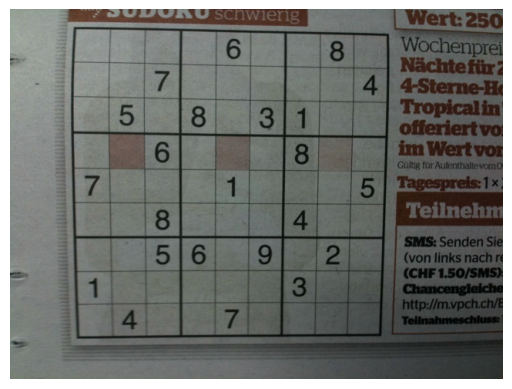

In [264]:
image = data[46]
cv.imwrite("./figures/sampleInputImage.png", image)
plt.axis('off')
plt.imshow(image)

#### Sudoku Detection

Gray Scale Conversion

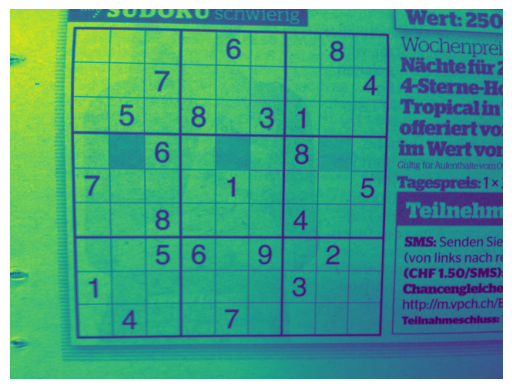

In [265]:
imageGrayScale = cv.cvtColor(image.copy(), cv.COLOR_BGR2GRAY)
cv.imwrite("./figures/sampleInputImageGrayScale.png", imageGrayScale)
plt.axis('off')
plt.imshow(imageGrayScale)

Initial Threshold

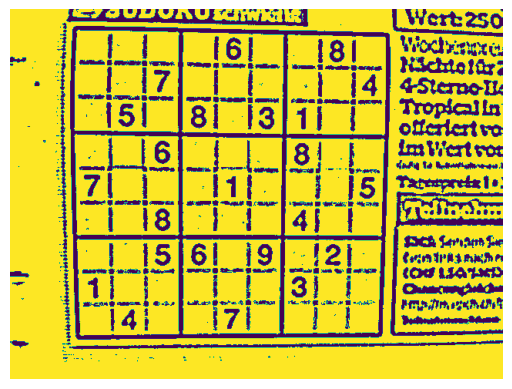

In [250]:
blurred = cv.GaussianBlur(imageGrayScale, (7, 7), 3)
thresh = cv.adaptiveThreshold(blurred, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, 11, 2)
thresh = cv.bitwise_not(thresh)
_, thresh = cv.threshold(thresh, 128, 255, cv.THRESH_BINARY_INV)
cv.imwrite("./figures/sampleInputImageThresholded.png", thresh)
plt.axis('off')
plt.imshow(thresh)

Find Contours

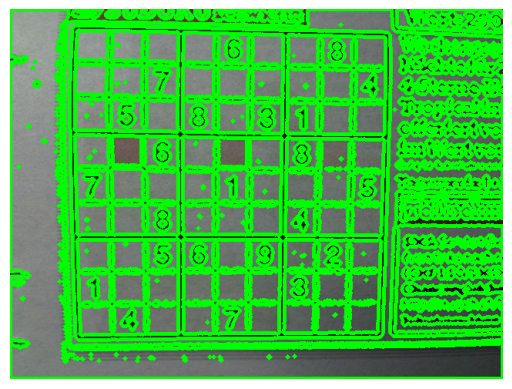

In [251]:
_contours_, _ = cv.findContours(thresh, cv.RETR_LIST, cv.CHAIN_APPROX_SIMPLE)
cv.imwrite("./figures/sampleInputImageAllContoursDrawn.png", cv.drawContours(image.copy(), _contours_, -1, ContourColor, 3))
plt.axis('off')
plt.imshow(cv.drawContours(image.copy(), _contours_, -1, (0, 255, 0), 3))

Check Size Of Found Contours

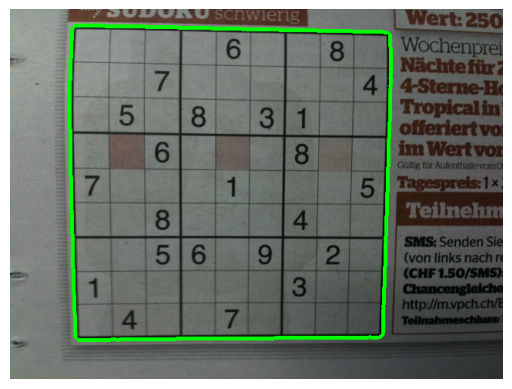

In [252]:
_contours = checkContoursForSize(image.copy(), _contours_)
cv.imwrite("./figures/sampleInputImageSizeCheckedContoursDrawn.png", cv.drawContours(image.copy(), _contours, -1, ContourColor, 3))
plt.axis('off')
plt.imshow(cv.drawContours(image.copy(), _contours, -1, (0, 255, 0), 3))

Check Shape Of Found Contours

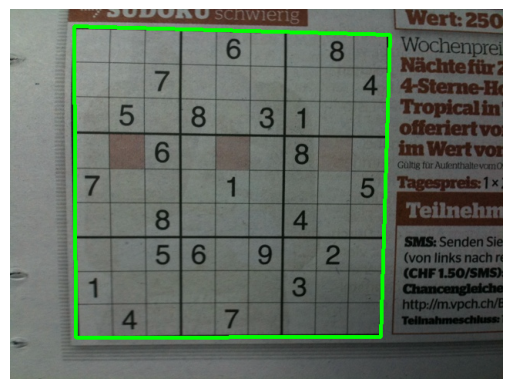

In [253]:
contours = checkContoursForSquares(_contours)
cv.imwrite("./figures/sampleInputImageShapeCheckedContoursDrawn.png", cv.drawContours(image.copy(), contours, -1, ContourColor, 3))
plt.axis('off')
plt.imshow(cv.drawContours(image.copy(), contours, -1, (0, 255, 0), 3))

Extract Sudoku

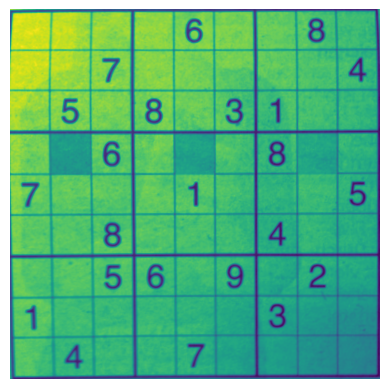

In [254]:
sudokuImageGrayScale = None

if len(contours) != 0:
    if len(contours) > 1: 
        contours = sorted(contours, key=cv.contourArea, reverse=True)
        
    sudokuContour = contours[0]

    sudokuContour = sudokuContour.reshape(4, 2)
    sudokuImageGrayScale = four_point_transform(imageGrayScale, sudokuContour)
    sudokuImageGrayScale = cv.resize(sudokuImageGrayScale, (900, 900))

    cv.imwrite("./figures/extractedSudokuImageGrayScale.png", sudokuImageGrayScale)
    plt.axis('off')
    plt.imshow(sudokuImageGrayScale)

#### Cell Extraction

Cell Retrieval

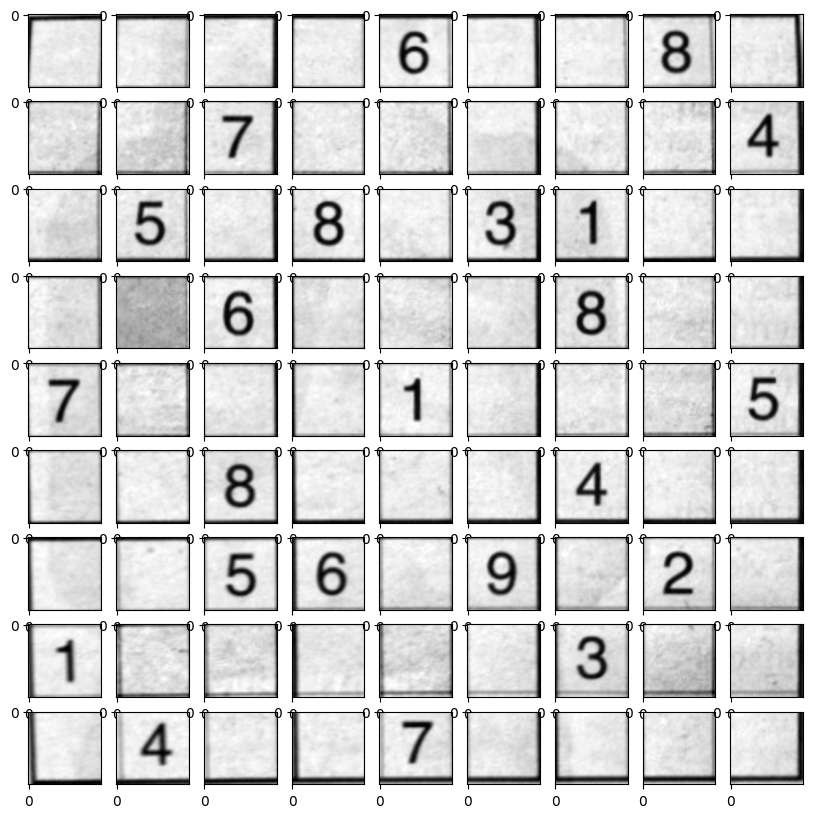

In [275]:
cellImages = retrieveCellsFromSudokuImage(sudokuImageGrayScale)
fig, axs = plt.subplots(9, 9, figsize=(10, 10))

for xIndex, row in enumerate(cellImages):
    for yIndex, cellImage in enumerate(row):
        axs[xIndex, yIndex].set_xticks([0, cellImage.shape[0]])
        axs[xIndex, yIndex].set_yticks([0, cellImage.shape[1]])
        axs[xIndex, yIndex].imshow(cellImage, cmap='gray')
        if xIndex < 3 and yIndex < 3:
            cv.imwrite(f"./figures/extractedSudokuImageGrayScaleCell{xIndex}{yIndex}.png", cellImage)
plt.savefig("./figures/extractedSudokuImageGrayScaleCells.png")

Cell Preprocessing

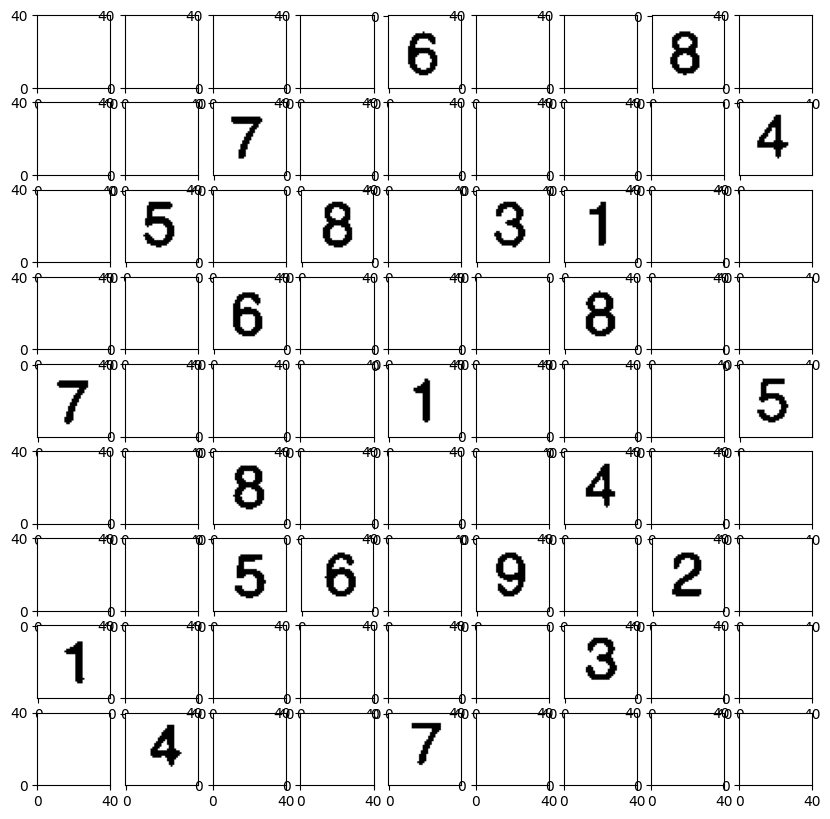

In [274]:
cellImages = retrieveCellsFromSudokuImage(sudokuImageGrayScale)
fig, axs = plt.subplots(9, 9, figsize=(10, 10))

for xIndex, row in enumerate(cellImages):
    for yIndex, cellImage in enumerate(row):
        cellImageResized = cv.resize(cellImage.copy(), (40, 40))
        needsClassification, cellImageResized = preprocessCellImage(cellImageResized)
        axs[xIndex, yIndex].set_xticks([0, 40])
        axs[xIndex, yIndex].set_yticks([0, 40])
        if cellImageResized is not None and needsClassification:
            cellImageResized = 255 - cellImageResized
            axs[xIndex, yIndex].imshow(cellImageResized, cmap='gray')
            if xIndex < 3 and yIndex < 3:
                cv.imwrite(f"./figures/extractedSudokuImagePreprocessedCell{xIndex}{yIndex}.png", cellImageResized)
        else:
            if xIndex < 3 and yIndex < 3:
                cv.imwrite(f"./figures/extractedSudokuImagePreprocessedCell{xIndex}{yIndex}.png", (np.ones((40, 40)) * 255).astype(np.uint8))

plt.savefig("./figures/extractedSudokuImagePreprocessedCells.png")

#### Sudoku Solving

#### Sudoku Remapping

In [257]:
foundSudoku = np.zeros((9, 9))

model = torch.load("./data/models/pixel.pth")
cellImages = retrieveCellsFromSudokuImage(sudokuImageGrayScale)

for xIndex, row in enumerate(cellImages): 
    for yIndex, cell in enumerate(row):


        cell = cv.resize(cell, (40, 40))
        needsClassification, cell = preprocessCellImage(cell)
        
        if not needsClassification: 
            continue

        cell = ((255 - cell) / 255).astype(np.uint8)
        X: np.ndarray = pixelFeatureFunction(cell)
        X = torch.tensor(X, dtype=torch.float32)
        y = model(X)
        y = y.detach().cpu()
        digit = torch.argmax(y, 0).item() + 1
        foundSudoku[xIndex, yIndex] = digit

print(foundSudoku)

[[0. 0. 0. 0. 6. 0. 0. 8. 0.]
 [0. 0. 7. 0. 0. 0. 0. 0. 4.]
 [0. 5. 0. 8. 0. 3. 1. 0. 0.]
 [0. 0. 6. 0. 0. 0. 8. 0. 0.]
 [7. 0. 0. 0. 1. 0. 0. 0. 5.]
 [0. 0. 8. 0. 0. 0. 4. 0. 0.]
 [0. 0. 5. 6. 0. 9. 0. 2. 0.]
 [1. 0. 0. 0. 0. 0. 3. 0. 0.]
 [0. 4. 0. 0. 7. 0. 0. 0. 0.]]


In [258]:
isSolved, solvedSudoku = solveSudoku(foundSudoku)
solvedSudoku = solvedSudoku.astype(np.uint8)
solvedSudoku

array([[2, 3, 1, 7, 6, 4, 5, 8, 9],
       [8, 6, 7, 1, 9, 5, 2, 3, 4],
       [9, 5, 4, 8, 2, 3, 1, 6, 7],
       [4, 9, 6, 2, 5, 7, 8, 1, 3],
       [7, 2, 3, 4, 1, 8, 6, 9, 5],
       [5, 1, 8, 9, 3, 6, 4, 7, 2],
       [3, 8, 5, 6, 4, 9, 7, 2, 1],
       [1, 7, 9, 5, 8, 2, 3, 4, 6],
       [6, 4, 2, 3, 7, 1, 9, 5, 8]], dtype=uint8)

Sudoku Image Creation

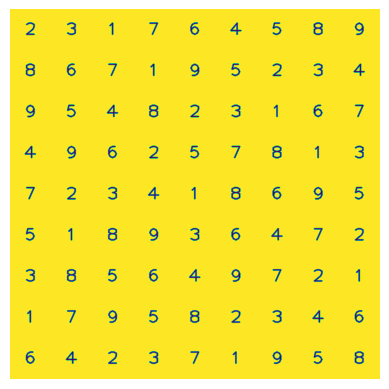

In [259]:
solvedSudokuImage = createSudokuImageFromSudoku(solvedSudoku)
cv.imwrite("./figures/solvedSudokuImageGrayScale.png", solvedSudokuImage)
plt.axis('off')
plt.imshow(solvedSudokuImage)

Reversed Sudoku

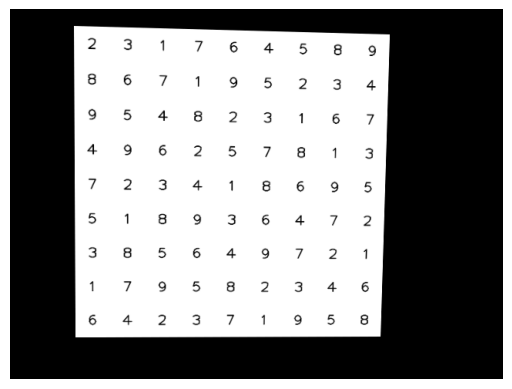

In [260]:
reversedSolvedSudokuImage = createReversedSudoku(image, solvedSudokuImage, sudokuContour)
cv.imwrite("./figures/reversedSolvedSudokuImageGrayScale.png", reversedSolvedSudokuImage)
plt.axis('off')
plt.imshow(reversedSolvedSudokuImage)

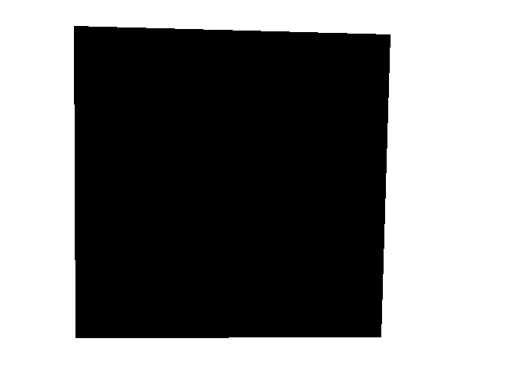

In [261]:
sudokuMask = createSudokuMask(image, sudokuContour)
cv.imwrite("./figures/sudokuMask.png", sudokuMask)
plt.axis('off')
plt.imshow(sudokuMask)

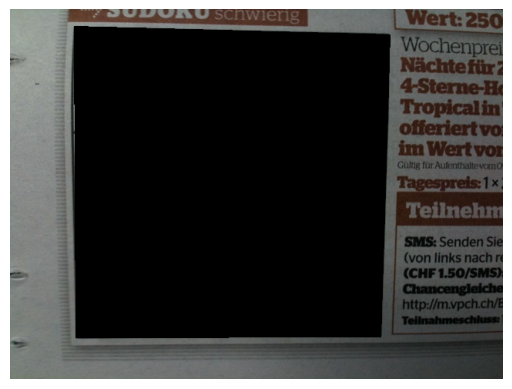

In [262]:
maskedInput = np.zeros_like(image) + image * ( sudokuMask / 255 )
maskedInput = maskedInput.astype(np.uint8)
cv.imwrite("./figures/maskedSampleInputImage.png", maskedInput)
plt.axis('off')
plt.imshow(maskedInput)

Final Output

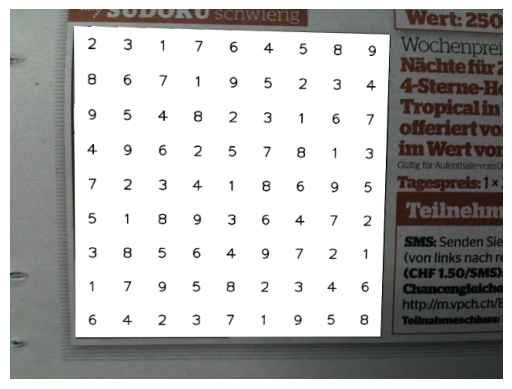

In [276]:
output = reversedSolvedSudokuImage + maskedInput
cv.imwrite("./figures/sampleInputImageWithRemappedSolvedSudokuImage.png", output)
plt.axis('off')
plt.imshow(output)

#### XXX